# Deep Learning Course - Exercise 3

* Alon Mizrahi 312284706
* Nimrod Curtis 311230924

## Mount folder 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


## Import libraries

In [2]:
import os
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from enum import Enum, auto
from torchvision import datasets, transforms, models
from torchvision.utils import save_image
import pandas as pd
import tqdm.notebook as tq
import matplotlib.pyplot as plt



# Hyper parameters

In [3]:
DIM = 64 # Model dimensionality
BATCH_SIZE = 64 # Batch size
LAMBDA = 10 # Gradient penalty lambda hyperparameter
IMG_DIM = 32
OUTPUT_DIM = IMG_DIM ** 2 
LATENT_SZ = 128
KERNEL_SZ = 4
PAD_SZ = 1
STRIDE_SZ = 2

device = "cuda" if torch.cuda.is_available() else "cpu" ## delete ?
use_cuda = torch.cuda.is_available()
if use_cuda:
    gpu = 0

## For the instructor

In [5]:
## Insert the assignment dir path according to your setup
DIR_PATH = '/content/gdrive/MyDrive/Deep Learning Course/Exercises/EX_3_VAE_GAN_WGAN/312284706_311230924_ex3'


## Utils

In [6]:
def getMnistData():
    # Apply normalization over imported images:
    transform = transforms.Compose([transforms.ToTensor(), transforms.Pad(2),
                                    transforms.Normalize([0.5], [0.5])])

    # Import Train and Test sets:
    trainset = datasets.FashionMNIST(root="./Dataset", download=True, train=True, transform=transform)
    trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testset = datasets.FashionMNIST(root="./Dataset", download=True, train=False, transform=transform)
    testLoader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

    return trainset, trainLoader, testset, testLoader


def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.cuda(gpu) if use_cuda else alpha

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    if use_cuda:
        interpolates = interpolates.cuda(gpu)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates.view(BATCH_SIZE, 1, IMG_DIM, IMG_DIM))

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(gpu) if use_cuda else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = (gradients.norm(2, dim=1) - 1) ** 2
    return gradient_penalty


def setWeightsFreeze(net, isFreeze):
    for p in net.parameters():  # reset requires_grad
        p.requires_grad = not isFreeze  # they are set to False below in netG update

class NetType(Enum):
    Generator = auto()
    Discriminator = auto()

class GanType(Enum):
    DCGan = auto()
    WGan = auto()

RESULTS_DIR = os.path.join(DIR_PATH, 'results_section4')
if not os.path.exists(RESULTS_DIR):
  os.mkdir(RESULTS_DIR)

pathes_dic = {}

for genType in [GanType.DCGan, GanType.WGan]:
  ## Train:
  pathes_dic[genType.name] = {'loss_pckl_path':os.path.join(RESULTS_DIR,f'{genType.name}_lossLog'),
                              'genWeights_path':os.path.join(RESULTS_DIR,f'{genType.name}_genWeights.pt'),
                              'discWeights_path':os.path.join(RESULTS_DIR,f'{genType.name}_discWeights.pt'),
                              'convergence_graph':os.path.join(RESULTS_DIR,f'{genType.name}_convergence Graph.png')}

# GAN Architectures

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        preprocess = nn.Sequential(
            nn.Linear(LATENT_SZ, 4 * 4 * 4 * DIM),
            nn.BatchNorm1d(4 * 4 * 4 * DIM),
            nn.ReLU(True),
        )

        block1 = nn.Sequential(
            nn.ConvTranspose2d(4 * DIM, 2 * DIM, KERNEL_SZ, STRIDE_SZ, PAD_SZ),
            nn.BatchNorm2d(2 * DIM),
            nn.ReLU(True),
        )

        block2 = nn.Sequential(
            nn.ConvTranspose2d(2 * DIM, DIM, KERNEL_SZ, STRIDE_SZ, PAD_SZ),
            nn.BatchNorm2d(DIM),
            nn.ReLU(True),
        )
        deconv_out = nn.ConvTranspose2d(DIM, 1, KERNEL_SZ, STRIDE_SZ, PAD_SZ)

        self.preprocess = preprocess
        self.block1 = block1
        self.block2 = block2
        self.deconv_out = deconv_out
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.preprocess(input)
        output = output.view(-1, 4 * DIM, 4, 4)
        output = self.block1(output)
        output = self.block2(output)
        output = self.deconv_out(output)
        output = self.tanh(output)
        # print(output.shape)
        return output


class Discriminator(nn.Module):
    def __init__(self, ganType):
        super(Discriminator, self).__init__()
        if ganType == GanType.DCGan:
            main = nn.Sequential(
                nn.Conv2d(1, DIM, KERNEL_SZ, STRIDE_SZ, PAD_SZ),
                nn.LeakyReLU(),
                nn.Conv2d(DIM, 2 * DIM, KERNEL_SZ, STRIDE_SZ, PAD_SZ),
                nn.BatchNorm2d(2 * DIM),
                nn.LeakyReLU(),
                nn.Conv2d(2 * DIM, 4 * DIM, KERNEL_SZ, STRIDE_SZ, PAD_SZ),
                nn.BatchNorm2d(4 * DIM),
                nn.LeakyReLU(),
            )
        else:
            main = nn.Sequential(
                nn.Conv2d(1, DIM, KERNEL_SZ, STRIDE_SZ, PAD_SZ),
                nn.LeakyReLU(),
                nn.Conv2d(DIM, 2 * DIM, KERNEL_SZ, STRIDE_SZ, PAD_SZ),
                nn.LeakyReLU(),
                nn.Conv2d(2 * DIM, 4 * DIM, KERNEL_SZ, STRIDE_SZ, PAD_SZ),
                nn.LeakyReLU(),
            )
        self.main = main
        self.linear = nn.Linear(4*4*4*DIM, 1)


    def forward(self, input):
        # print(input.shape)
        output = self.main(input)
        output = output.view(-1, 4*4*4*DIM)
        output = self.linear(output)
        return output


In [ ]:
def train(ganType, nIters = 10000):

    netG = Generator()
    netD = Discriminator(ganType)

    lossLog = pd.DataFrame(index=range(nIters), columns=['Discriminator', 'Generator'])

    # set parameter that depend on the type of GAN we are training:
    if ganType==GanType.DCGan:
        sigmoid = torch.nn.Sigmoid()
        bceLoss = torch.nn.BCELoss()
        CRITIC_ITERS = 1
        optimizerD = optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))
        optimizerG = optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))
    else:
        CRITIC_ITERS = 5
        optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))
        optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))


    if use_cuda:
        netD = netD.cuda(gpu)
        netG = netG.cuda(gpu)

    _, trainData, _, _ = getMnistData()

    pbar = tq.tqdm(range(nIters+1), desc='Training Progress')
    for iteration in pbar:
      
        ## Update Discrminator/Critic:
        setWeightsFreeze(netD, False)
        setWeightsFreeze(netG, True)

        for iter_d in range(CRITIC_ITERS):
            _data, _ = next(iter(trainData))
            real_data = torch.Tensor(_data)
            if use_cuda:
                real_data = real_data.cuda(gpu)
            real_data_v = autograd.Variable(real_data)

            netD.zero_grad()

            # feed real data
            D_real = netD(real_data_v)

            # feed fake data:
            noise = torch.randn(BATCH_SIZE, LATENT_SZ)
            if use_cuda:
                noise = noise.cuda(gpu)
            noisev = autograd.Variable(noise)  # totally freeze netG
            fake = autograd.Variable(netG(noisev).data)
            inputv = fake
            D_fake = netD(inputv)

            # Calculate Loss:
            if ganType == GanType.WGan:
                # train with gradient penalty
                gradient_penalty = calc_gradient_penalty(netD, real_data_v.view(BATCH_SIZE, -1), fake.view(BATCH_SIZE, -1))
                discBatchLoss = D_fake - D_real + LAMBDA * gradient_penalty
                discLoss = discBatchLoss.mean()

            elif ganType == GanType.DCGan:
                discReal = bceLoss(sigmoid(D_real), torch.ones_like(D_real))
                discFake = bceLoss(sigmoid(D_fake), torch.zeros_like(D_real))
                discLoss = 0.5 * (discReal + discFake)
            else:
                raise Exception('Illegal GAN Configuration!')

            discLoss.backward()
            optimizerD.step()

            lossLog.loc[iteration, 'Discriminator'] = discLoss.cpu().detach().numpy()

        ## Update Generator:
        setWeightsFreeze(netD, True)
        setWeightsFreeze(netG, False)

        netG.zero_grad()

        # generate and feed fake data:
        noise = torch.randn(BATCH_SIZE, LATENT_SZ)
        if use_cuda:
            noise = noise.cuda(gpu)
        noisev = autograd.Variable(noise)
        fake = netG(noisev)
        D_fake = netD(fake)

        # Calculate loss:
        if ganType == GanType.WGan:
            genLoss = -D_fake.mean()
        elif ganType == GanType.DCGan:
            genLoss = bceLoss(sigmoid(D_fake), torch.ones_like(D_fake))
        else:
            raise Exception('Illegal GAN Configuration!')

        lossLog.loc[iteration, 'Generator'] = genLoss.cpu().detach().numpy()

        genLoss.backward()
        optimizerG.step()

        if iteration % 100 == 0:
          pbar.set_postfix_str(f"  {ganType.name}\t Generator Loss: {lossLog.loc[iteration, 'Generator']:.3f}\t"
                  f"Discriminator Loss: {lossLog.loc[iteration, 'Discriminator']:.3f}")

            

    return lossLog, netG.state_dict(), netD.state_dict()

## Run Training

DCGan Training:


100%|██████████| 26421880/26421880 [00:02<00:00, 12429741.16it/s]


Extracting ./Dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./Dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 214206.53it/s]


Extracting ./Dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./Dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3914656.00it/s]


Extracting ./Dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./Dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20198575.30it/s]

Extracting ./Dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./Dataset/FashionMNIST/raw



Training Progress:   0%|          | 0/10001 [00:00<?, ?it/s]

WGan Training:


Training Progress:   0%|          | 0/10001 [00:00<?, ?it/s]

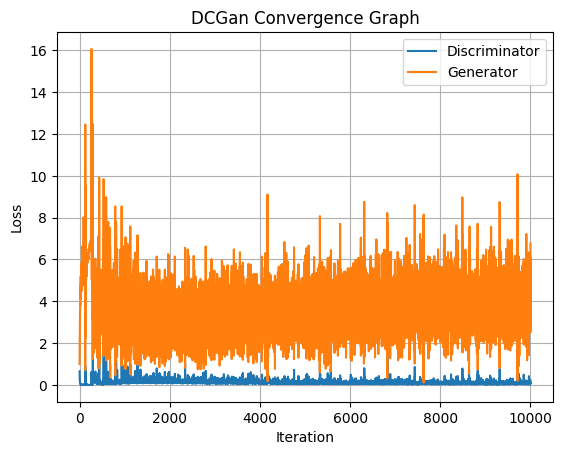

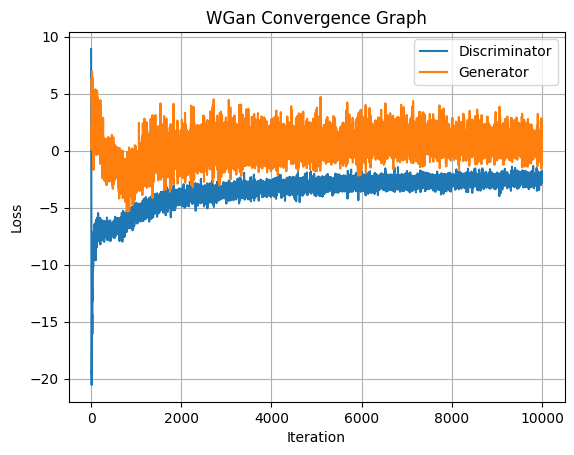

In [ ]:
import matplotlib.pyplot as plt
import pickle


for genType in [GanType.DCGan, GanType.WGan]:
  ## Train:

  print(f'{genType.name} Training:')
  lossLog, genWeights, discWeights = train(genType, nIters=10000) 
  pickle.dump(lossLog, open(pathes_dic[genType.name]['loss_pckl_path'], 'wb'))
  open(pathes_dic[genType.name]['loss_pckl_path'], 'wb').close()
  torch.save(genWeights, pathes_dic[genType.name]['genWeights_path'])
  torch.save(discWeights, pathes_dic[genType.name]['discWeights_path'])


  # plot training results:
  f, ax = plt.subplots()
  lossLog.astype(float).plot(ax=ax)
  ax.set_xlabel('Iteration')
  ax.set_ylabel('Loss')
  ax.set_title(genType.name + ' Convergence Graph')
  ax.grid()
  f.savefig(pathes_dic[genType.name]['convergence_graph'])

## Display

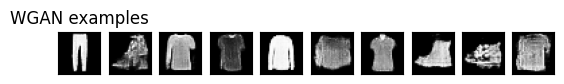

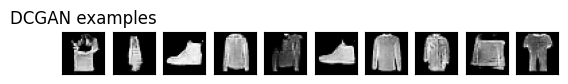

In [69]:
fakes = []
torch.random.manual_seed(42)

genWeights = torch.load(pathes_dic[GanType.WGan.name]['genWeights_path'],map_location=torch.device('cpu'))
genNet = Generator()
if use_cuda: genNet = genNet.cuda(gpu)
genNet.load_state_dict(genWeights)

noise = torch.randn(BATCH_SIZE, LATENT_SZ)
if use_cuda: noise = noise.cuda(gpu)
noisev = autograd.Variable(noise)  
fake = autograd.Variable(genNet(noisev).data) # forward

fig, ax = plt.subplots(1, 10)
ax[0].set_title("WGAN examples")
for i in range(10):
  wgan_img = fake[i].cpu().reshape((32,32))
  ax[i].imshow(wgan_img, cmap='gray')
  ax[i].set_xticks([]) 
  ax[i].set_yticks([])

wgan_pans = fake[0].cpu().reshape((32,32))
wgan_shirt = fake[3].cpu().reshape((32,32))

wgan_examples = [wgan_shirt, wgan_pans]

genWeights = torch.load(pathes_dic[GanType.DCGan.name]['genWeights_path'],map_location=torch.device('cpu'))
genNet = Generator()
if use_cuda:
    genNet = genNet.cuda(gpu)
genNet.load_state_dict(genWeights)
noise = torch.randn(BATCH_SIZE, LATENT_SZ)
if use_cuda:
    noise = noise.cuda(gpu)
noisev = autograd.Variable(noise)  # totally freeze netG
fake = autograd.Variable(genNet(noisev).data)

fig, ax = plt.subplots(1, 10)
ax[0].set_title("DCGAN examples")
for i in range(10):
  wgan_img = fake[i].cpu().reshape((32,32))
  ax[i].imshow(wgan_img, cmap='gray')
  ax[i].set_xticks([]) 
  ax[i].set_yticks([])

DCgan_pans = fake[24].cpu().reshape((32,32))
DCgan_shirt = fake[9].cpu().reshape((32,32))

dcgan_examples = [DCgan_shirt, DCgan_pans]

plt.imshow(DCgan_shirt, cmap='gray')

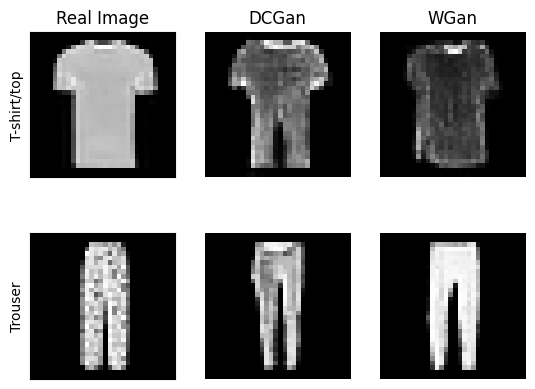

In [70]:
import random
_, _, testSet, _ = getMnistData()
classes = [0, 1]
#{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
fig, ax = plt.subplots(2, 3)
for i, classNum in enumerate(classes):
  className = testSet.classes[classNum]
  testSetImgIdx = random.sample(np.argwhere(testSet.targets==classNum)[0].tolist(), 1)
  testSetImg = testSet.data[testSetImgIdx].numpy().squeeze()
  ax[i,0].imshow(np.pad(testSetImg, 2), cmap='gray')
  ax[i,0].set_ylabel(className)
  ax[i,0].set_xticks([]) 
  ax[i,0].set_yticks([]) 
  ax[i,0].tick_params(axis=u'both', which=u'both',length=0)
  if i==0:
      ax[i,0].set_title('Real Image')
  for j, exmpl in enumerate([dcgan_examples, wgan_examples]):
      ax[i, j+1].imshow(exmpl[i], cmap='gray')
      #if i==0:
        #ax[i, j+1].set_title(genType.name)
      ax[i, j+1].axis('off')
      ax[0, 1].set_title('DCGan')
      ax[0, 2].set_title('WGan')

      
fig.savefig(os.path.join(RESULTS_DIR,'comparsion.png'))